In [36]:
import pandas as pd
import numpy as np
import itertools as it

import pickle as pcl

from scipy.spatial.distance import cdist

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

from collections import Counter

import brewer2mpl

# Get "Set2" colors from ColorBrewer (all colorbrewer scales: http://bl.ocks.org/mbostock/5577023)
set2 = brewer2mpl.get_map('Set2', 'qualitative', 8).mpl_colors
gnbu = brewer2mpl.get_map('GnBu', 'sequential', 5).mpl_colors


from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import MeanShift

import hightolowz

In [37]:
#%run load_wmap1.py

In [38]:
L = 480.279

In [39]:
gals = pd.read_csv('data/planck1/henriques2015a_z3p95_mstar.csv', 
                   skiprows=101, skipfooter=1, engine='python')

Eigenvectors

https://github.com/pierrepo/principal_axes/blob/master/principal_axes.py

In [291]:
cluster = np.unique(gals[gals['z0_central_mcrit200'] > 1e4]['z0_centralId'])[0]

print np.log10(np.unique(gals[gals['z0_centralId']==cluster]['z0_central_mcrit200']) * 1e10)

# correct for periodic boundary conditions
coods = gals[gals['z0_centralId'] == cluster][['zn_x','zn_y','zn_z']].copy()

[ 14.58185886]


In [292]:
if np.abs(coods['zn_x'].max() - coods['zn_x'].min()) > L/2:
    coods['zn_x'] = coods['zn_x'] - L
    coods.loc[coods['zn_x'] < -L/2, 'zn_x'] = gals[gals['z0_centralId'] == cluster]['zn_x'][coods['zn_x'] < -L/2]

if np.abs(coods['zn_y'].max() - coods['zn_y'].min()) > L/2:
    coods['zn_y'] = coods['zn_y'] - L
    coods.loc[coods['zn_y'] < -L/2, 'zn_y'] = gals[gals['z0_centralId'] == cluster]['zn_y'][coods['zn_y'] < -L/2]

if np.abs(coods['zn_z'].max() - coods['zn_z'].min()) > L/2:
    coods['zn_z'] = coods['zn_z'] - L
    coods.loc[coods['zn_z'] < -L/2, 'zn_z'] = gals[gals['z0_centralId'] == cluster]['zn_z'][coods['zn_z'] < -L/2]

center = np.mean(coods)
coods = coods - center

In [293]:
inertia = np.dot(coods.transpose(), coods)
e_values, e_vectors = np.linalg.eig(inertia)

In [294]:
e_vectors = e_vectors[e_values.argsort()][::-1]
e_values = e_values[e_values.argsort()][::-1]

<IPython.core.display.Javascript object>


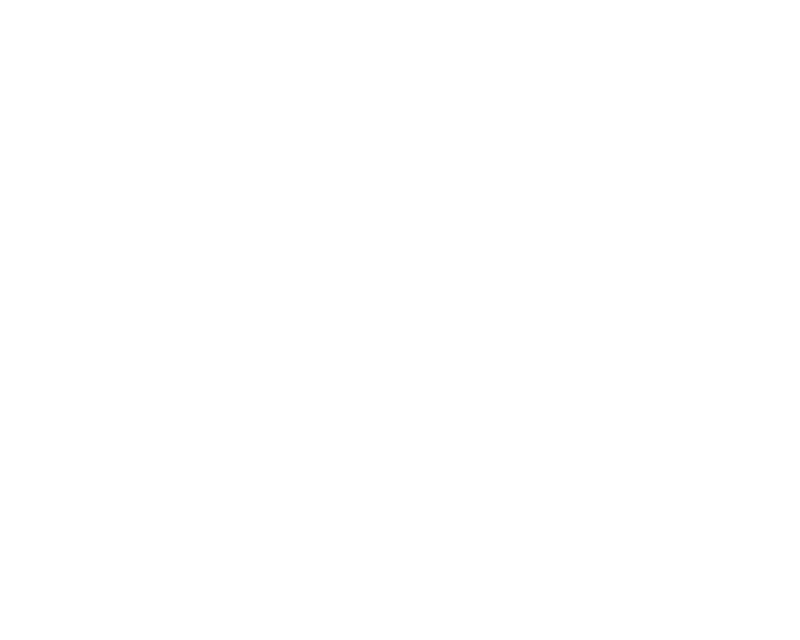

[ 0.15021372 -0.25274995  0.95579982]
[-0.85628159 -0.51650538 -0.00201033]
[ 0.49418386 -0.81813181 -0.29401132]


In [296]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(coods['zn_x'],
           coods['zn_y'],
           zs=coods['zn_z'])
#             ,c = gals[gals['z0_centralId'] == cluster]['delta_gal_20'],
#           cmap='viridis')

# fig.colorbar(p)

cols = ['r','b','g']

for j in range(len(e_vectors)):
    print e_vectors[j]
    
    e_components = e_vectors[j] * e_values[j] / 150

    ax.plot([0, e_components[0]], 
             [0, e_components[1]], 
             [0, e_components[2]], c=cols[j])

ax.view_init(30, 10)



In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

Calculate for all clusters

In [5]:
gals_z6p42 = pd.read_csv('data/planck1/henriques2015a_z6p42_mstar.csv', 
                   skiprows=101, skipfooter=1, engine='python')

gals_z5p03 = pd.read_csv('data/planck1/henriques2015a_z5p03_mstar.csv', 
                   skiprows=101, skipfooter=1, engine='python')

gals_z3p95 = pd.read_csv('data/planck1/henriques2015a_z3p95_mstar.csv', 
                   skiprows=101, skipfooter=1, engine='python')

gals_z3p10 = pd.read_csv('data/planck1/henriques2015a_z3p10_mstar.csv', 
                   skiprows=102, skipfooter=1, engine='python')

In [6]:
def calc_eigs(gals):

    eig_values = []

    for cluster in np.unique(gals[gals['z0_central_mcrit200'] > 1e4]['z0_centralId']):

        coods = gals[gals['z0_centralId'] == cluster][['zn_x','zn_y','zn_z']].copy()

        if np.abs(coods['zn_x'].max() - coods['zn_x'].min()) > L/2:
            coods['zn_x'] = coods['zn_x'] - L
            coods['zn_x'].loc[coods['zn_x'] < -L/2] = gals[gals['z0_centralId'] == cluster]['zn_x'][coods['zn_x'] < -L/2]

        if np.abs(coods['zn_y'].max() - coods['zn_y'].min()) > L/2:
            coods['zn_y'] = coods['zn_y'] - L
            coods['zn_y'].loc[coods['zn_y'] < -L/2] = gals[gals['z0_centralId'] == cluster]['zn_y'][coods['zn_y'] < -L/2]

        if np.abs(coods['zn_z'].max() - coods['zn_z'].min()) > L/2:
            coods['zn_z'] = coods['zn_z'] - L
            coods['zn_z'].loc[coods['zn_z'] < -L/2] = gals[gals['z0_centralId'] == cluster]['zn_z'][coods['zn_z'] < -L/2]

        center = np.mean(coods)
        coods = coods - center

        inertia = np.dot(coods.transpose(), coods)
        e_values, e_vectors = np.linalg.eig(inertia)

        e_values.sort()
        eig_values.append(e_values[::-1])
        
    return eig_values

In [7]:
eig_vals_z6p42 = calc_eigs(gals_z6p42)
eig_vals_z5p03 = calc_eigs(gals_z5p03)
eig_vals_z3p95 = calc_eigs(gals_z3p95)
eig_vals_z3p10 = calc_eigs(gals_z3p10)

In [8]:
eig_vals_z6p42_ZERO = np.array(eig_vals_z6p42)[:,0] != 0
eig_vals_z5p03_ZERO = np.array(eig_vals_z5p03)[:,0] != 0
eig_vals_z3p95_ZERO = np.array(eig_vals_z3p95)[:,0] != 0
eig_vals_z3p10_ZERO = np.array(eig_vals_z3p10)[:,0] != 0

In [9]:
eig_vals_z6p42 = np.array(eig_vals_z6p42)[np.array(eig_vals_z6p42)[:,0] != 0].astype(float)
eig_vals_z5p03 = np.array(eig_vals_z5p03)[np.array(eig_vals_z5p03)[:,0] != 0].astype(float)
eig_vals_z3p95 = np.array(eig_vals_z3p95)[np.array(eig_vals_z3p95)[:,0] != 0].astype(float)
eig_vals_z3p10 = np.array(eig_vals_z3p10)[np.array(eig_vals_z3p10)[:,0] != 0].astype(float)

/home/chris/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':
/home/chris/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


In [10]:
eig_delta_z6p42 = np.array([[x[0]/sum(x), x[1]/sum(x), x[2]/sum(x)] for x in eig_vals_z6p42])
eig_delta_z5p03 = np.array([[x[0]/sum(x), x[1]/sum(x), x[2]/sum(x)] for x in eig_vals_z5p03])
eig_delta_z3p95 = np.array([[x[0]/sum(x), x[1]/sum(x), x[2]/sum(x)] for x in eig_vals_z3p95])
eig_delta_z3p10 = np.array([[x[0]/sum(x), x[1]/sum(x), x[2]/sum(x)] for x in eig_vals_z3p10])

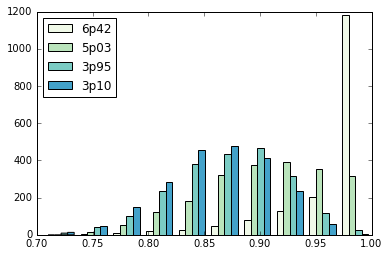

In [35]:
plt.hist([eig_delta_z6p42[:,0]+eig_delta_z6p42[:,1], 
          eig_delta_z5p03[:,0]+eig_delta_z5p03[:,1], 
          eig_delta_z3p95[:,0]+eig_delta_z3p95[:,1], 
          eig_delta_z3p10[:,0]+eig_delta_z3p10[:,1]],
        label=['6p42', '5p03','3p95','3p10'],
        color=[gnbu[0],gnbu[1],gnbu[2],gnbu[3]])

plt.legend(loc=2)

#plt.savefig('eig1plus2.png', bbox_inches='tight', dpi=300)

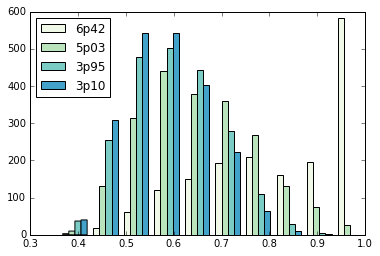

In [34]:
plt.hist([eig_delta_z6p42[:,0], 
          eig_delta_z5p03[:,0], 
          eig_delta_z3p95[:,0], 
          eig_delta_z3p10[:,0]],
        label=['6p42', '5p03','3p95','3p10'],
        color=[gnbu[0],gnbu[1],gnbu[2],gnbu[3]])

plt.legend(loc=2)

#plt.savefig('eig1.png', bbox_inches='tight', dpi=300)

### Convex Hull

In [40]:
from scipy.spatial import ConvexHull

In [41]:
cluster = np.unique(gals[gals['z0_central_mcrit200'] > 1e4]['z0_centralId'])[0]

print np.log10(np.unique(gals[gals['z0_centralId']==cluster]['z0_central_mcrit200']) * 1e10)

# correct for periodic boundary conditions
coods = gals[gals['z0_centralId'] == cluster][['zn_x','zn_y','zn_z']].copy()

[ 14.58185886]


In [45]:
hull = ConvexHull(coods)

In [46]:
for simplex in hull.simplices:
    plt.plot(coods[simplex, 0], coods[simplex, 1], 'k-')

NameError: name 'points' is not defined